# Task 1 – Search Engine: Robot de Entrega

**Proyecto 1 – Inteligencia Artificial**

Este notebook implementa el motor de búsqueda para un robot de entrega que:
1. **Task 1.1** – Discretiza una imagen de laberinto en una grilla de nodos
2. **Task 1.2** – Resuelve el laberinto con BFS y DFS (framework genérico OOP)
3. **Task 1.3** – Implementa A* con heurística de distancia Manhattan

## 0. Importación de Librerías

In [28]:
from __future__ import annotations

import os
import heapq
from abc import ABC, abstractmethod
from collections import deque
from enum import Enum
from typing import List, Tuple, Optional, Set, Dict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

## 1. Carga y Preprocesamiento de la Imagen

Se carga la imagen del laberinto (.png o .bmp), se convierte a un arreglo RGB NumPy y se valida que sea cuadrada.

**Convención de colores:**
| Color | Significado |
|-------|-------------|
| Blanco ~(255,255,255) | Camino libre |
| Negro (0,0,0) | Pared (intransitable) |
| Rojo ~(255,0,0) | Punto de inicio |
| Verde ~(0,255,0) | Meta (puede haber varias) |

Imagen cargada: assets\Test.bmp  →  582×582 px


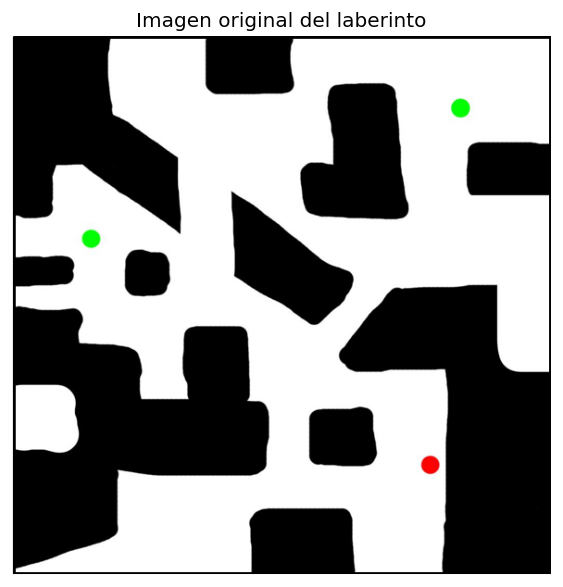

In [60]:
# ── Parámetro: ruta de la imagen ──────────────────────────────────────────────
IMAGE_PATH = os.path.join("assets", "Test.bmp")   # Cambiar según el laberinto

# ── Carpeta de salida para imágenes generadas ─────────────────────────────────
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Carga ─────────────────────────────────────────────────────────────────────
img = Image.open(IMAGE_PATH).convert("RGB")
img_array = np.array(img, dtype=np.uint8)

height, width, _ = img_array.shape
assert height == width, f"La imagen debe ser cuadrada, pero tiene dimensiones {width}x{height}"
print(f"Imagen cargada: {IMAGE_PATH}  →  {width}×{height} px")

# ── Vista previa ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_array)
ax.set_title("Imagen original del laberinto")
ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "01_original_image.png"), bbox_inches="tight")
plt.show()


## Task 1.1 – Discretización del Mundo

Se agrupa la imagen en *tiles* de `TILE_SIZE × TILE_SIZE` píxeles. Para cada tile se calcula el color promedio y se clasifica el nodo según umbrales de color.

### Tipos de nodo

```
FREE  = 0   (blanco)
WALL  = 1   (negro)
START = 2   (rojo)
GOAL  = 3   (verde)
```

In [32]:
# ── Enumeración de tipos de celda ─────────────────────────────────────────────

class CellType(Enum):
    """Tipos de celda en la grilla discretizada."""
    FREE  = 0
    WALL  = 1
    START = 2
    GOAL  = 3


# ── Umbrales de clasificación de color ────────────────────────────────────────

def classify_color(r: float, g: float, b: float) -> CellType:
    """Clasifica un color RGB promedio en un tipo de celda.

    Se usan umbrales relajados para tolerar artefactos de compresión en BMP/PNG.
    """
    # Negro  →  pared (todos los canales bajos)
    if r < 50 and g < 50 and b < 50:
        return CellType.WALL

    # Rojo  →  inicio (R dominante)
    if r > 150 and g < 100 and b < 100:
        return CellType.START

    # Verde  →  meta (G dominante)
    if g > 150 and r < 100 and b < 100:
        return CellType.GOAL

    # Todo lo demás → camino libre (incluyendo blanco)
    return CellType.FREE


# ── Discretización en tiles ───────────────────────────────────────────────────

def discretize(image: np.ndarray, tile_size: int = 10) -> np.ndarray:
    """Convierte una imagen RGB en una grilla discreta de CellType.

    Parameters
    ----------
    image : np.ndarray
        Arreglo (H, W, 3) con valores uint8.
    tile_size : int
        Número de píxeles por lado de cada tile.

    Returns
    -------
    grid : np.ndarray
        Matriz 2-D de objetos CellType con forma (rows, cols).
    """
    h, w, _ = image.shape
    rows = h // tile_size
    cols = w // tile_size

    grid = np.empty((rows, cols), dtype=object)

    for r in range(rows):
        for c in range(cols):
            # Extraer el tile
            tile = image[
                r * tile_size : (r + 1) * tile_size,
                c * tile_size : (c + 1) * tile_size,
            ]
            # Color promedio del tile
            avg = tile.mean(axis=(0, 1))  # (R, G, B) float
            grid[r, c] = classify_color(avg[0], avg[1], avg[2])

    return grid

In [33]:
# ── Ejecutar discretización ────────────────────────────────────────────────────
TILE_SIZE = 6  # Ajustar según resolución de la imagen

grid = discretize(img_array, tile_size=TILE_SIZE)
print(f"Grilla discretizada: {grid.shape[0]} filas × {grid.shape[1]} columnas  (tile_size={TILE_SIZE})")

Grilla discretizada: 97 filas × 97 columnas  (tile_size=6)


### Task 1.1 – Identificación de Inicio, Metas y Obstáculos

In [34]:
def extract_key_positions(
    grid: np.ndarray,
) -> Tuple[Tuple[int, int], List[Tuple[int, int]], int]:
    """Extrae las coordenadas de inicio, metas y cuenta de paredes.

    Si el área roja ocupa varios tiles, se calcula el centroide y los
    tiles restantes se reclasifican como FREE.

    Parameters
    ----------
    grid : np.ndarray
        Matriz 2-D de CellType.

    Returns
    -------
    start : (row, col)
    goals : list of (row, col)
    wall_count : int
    """
    start_tiles: List[Tuple[int, int]] = []
    goals: List[Tuple[int, int]] = []
    wall_count = 0

    rows, cols = grid.shape
    for r in range(rows):
        for c in range(cols):
            cell = grid[r, c]
            if cell == CellType.START:
                start_tiles.append((r, c))
            elif cell == CellType.GOAL:
                goals.append((r, c))
            elif cell == CellType.WALL:
                wall_count += 1

    assert len(start_tiles) > 0, "No se encontró un punto de inicio (rojo) en la imagen."
    assert len(goals) > 0, "No se encontró ninguna meta (verde) en la imagen."

    # Consolidar tiles START en un único centroide
    if len(start_tiles) == 1:
        start = start_tiles[0]
    else:
        avg_r = int(round(sum(r for r, _ in start_tiles) / len(start_tiles)))
        avg_c = int(round(sum(c for _, c in start_tiles) / len(start_tiles)))
        start = (avg_r, avg_c)
        print(f"  ⚠ {len(start_tiles)} tiles START detectados → centroide en {start}")

    # Reclasificar los tiles START sobrantes como FREE
    for r, c in start_tiles:
        if (r, c) != start:
            grid[r, c] = CellType.FREE
    grid[start[0], start[1]] = CellType.START

    return start, goals, wall_count


# ── Extraer posiciones ────────────────────────────────────────────────────────
start_pos, goal_positions, n_walls = extract_key_positions(grid)

total_cells = grid.shape[0] * grid.shape[1]
print(f"Inicio     : {start_pos}")
print(f"Metas ({len(goal_positions):>2}) : {goal_positions}")
print(f"Paredes    : {n_walls}  ({100*n_walls/total_cells:.1f}% de la grilla)")
print(f"Libres     : {total_cells - n_walls - 1 - len(goal_positions)}")

  ⚠ 7 tiles START detectados → centroide en (77, 75)
Inicio     : (77, 75)
Metas (15) : [(11, 80), (12, 79), (12, 80), (12, 81), (13, 79), (13, 80), (13, 81), (14, 80), (35, 13), (35, 14), (36, 13), (36, 14), (36, 15), (37, 13), (37, 14)]
Paredes    : 4080  (43.4% de la grilla)
Libres     : 5313


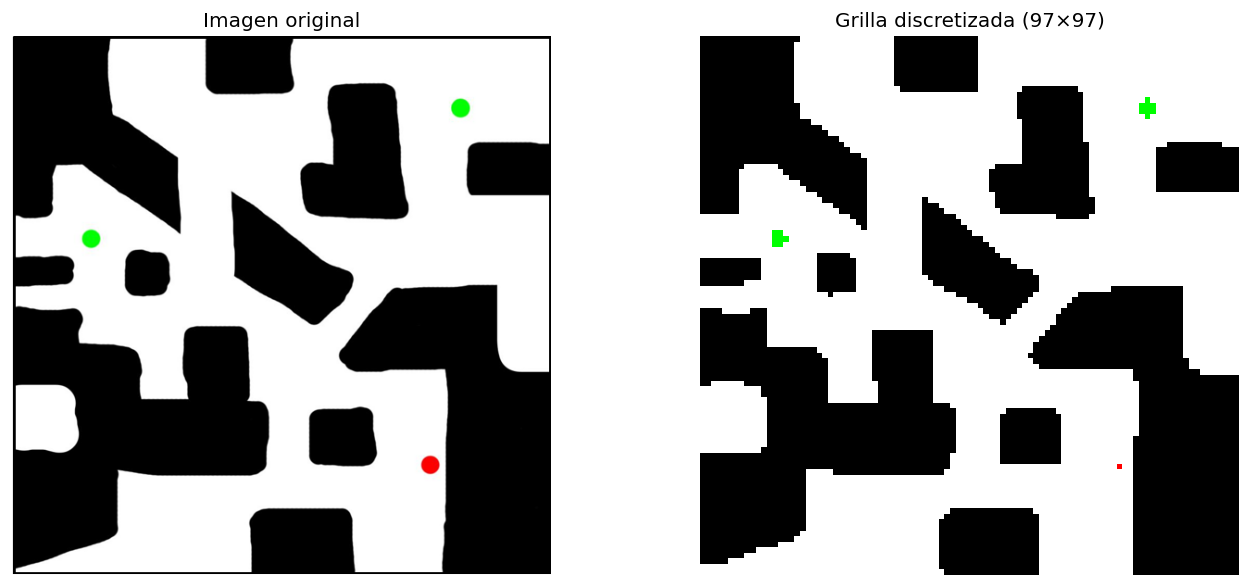

In [35]:
# ── Visualización de la grilla discretizada ───────────────────────────────────

def grid_to_rgb(grid: np.ndarray) -> np.ndarray:
    """Convierte la grilla de CellType a una imagen RGB para visualización."""
    color_map = {
        CellType.FREE:  [255, 255, 255],  # blanco
        CellType.WALL:  [0,   0,   0  ],  # negro
        CellType.START: [255, 0,   0  ],  # rojo
        CellType.GOAL:  [0,   255, 0  ],  # verde
    }
    rows, cols = grid.shape
    rgb = np.zeros((rows, cols, 3), dtype=np.uint8)
    for r in range(rows):
        for c in range(cols):
            rgb[r, c] = color_map[grid[r, c]]
    return rgb

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_array)
axes[0].set_title("Imagen original")
axes[0].axis("off")

axes[1].imshow(grid_to_rgb(grid), interpolation="nearest")
axes[1].set_title(f"Grilla discretizada ({grid.shape[0]}×{grid.shape[1]})")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "02_discretized_grid.png"), bbox_inches="tight")
plt.show()

## Task 1.2 – Framework Abstracto de Problemas de Búsqueda (OOP)

Se define una **clase abstracta** `SearchProblem` que modela formalmente un problema de búsqueda con:
- `initial_state()` – estado inicial
- `goal_test(state)` – prueba de meta
- `actions(state)` – acciones disponibles
- `result(state, action)` – estado sucesor
- `step_cost(state, action, next_state)` – costo del paso

Luego se implementa `MazeProblem` que recibe la grilla discretizada y deduce las funciones del framework automáticamente.

In [52]:
# ── Clase abstracta: SearchProblem ─────────────────────────────────────────────

State = Tuple[int, int]  # (row, col)
Action = Tuple[int, int]  # delta (dr, dc)


class SearchProblem(ABC):
    """Interfaz genérica para definir un problema de búsqueda formal."""

    @abstractmethod
    def initial_state(self) -> State:
        """Retorna el estado inicial."""
        ...

    @abstractmethod
    def goal_test(self, state: State) -> bool:
        """Retorna True si `state` es un estado meta."""
        ...

    @abstractmethod
    def actions(self, state: State) -> List[Action]:
        """Retorna la lista de acciones válidas desde `state`."""
        ...

    @abstractmethod
    def result(self, state: State, action: Action) -> State:
        """Retorna el estado resultante de aplicar `action` en `state`."""
        ...

    @abstractmethod
    def step_cost(self, state: State, action: Action, next_state: State) -> float:
        """Retorna el costo de moverse de `state` a `next_state` vía `action`."""
        ...


# ── Implementación concreta: MazeProblem ─────────────────────────────────────

# Movimientos 4-conexos: arriba, abajo, izquierda, derecha
FOUR_CONNECTED: List[Action] = [(-1, 0), (1, 0), (0, -1), (0, 1)]


class MazeProblem(SearchProblem):
    """Problema de búsqueda en un laberinto discretizado.

    Parameters
    ----------
    grid : np.ndarray
        Matriz 2-D de CellType producida por `discretize()`.
    start : (row, col)
        Coordenadas del nodo de inicio.
    goals : list of (row, col)
        Coordenadas de los nodos meta.
    """

    def __init__(
        self,
        grid: np.ndarray,
        start: Tuple[int, int],
        goals: List[Tuple[int, int]],
    ) -> None:
        self.grid = grid
        self.rows, self.cols = grid.shape
        self._start = start
        self._goals: Set[Tuple[int, int]] = set(goals)

    # ── Interfaz SearchProblem ────────────────────────────────────────────────

    def initial_state(self) -> State:
        return self._start

    def goal_test(self, state: State) -> bool:
        return state in self._goals

    def actions(self, state: State) -> List[Action]:
        r, c = state
        valid: List[Action] = []
        for dr, dc in FOUR_CONNECTED:
            nr, nc = r + dr, c + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols:
                if self.grid[nr, nc] != CellType.WALL:
                    valid.append((dr, dc))
        return valid

    def result(self, state: State, action: Action) -> State:
        return (state[0] + action[0], state[1] + action[1])

    def step_cost(self, state: State, action: Action, next_state: State) -> float:
        # Task 1.3: costo uniforme = 1 para toda celda no-pared
        return 1.0


# ── Instanciar el problema ────────────────────────────────────────────────────
problem = MazeProblem(grid, start_pos, goal_positions)
print(f"MazeProblem creado: inicio={problem.initial_state()}, "
      f"metas={len(problem._goals)}, tamaño={problem.rows}×{problem.cols}")

MazeProblem creado: inicio=(77, 75), metas=15, tamaño=97×97


### Graph Search Genérico y clase Node

Se define la clase `Node` para representar nodos del árbol de búsqueda y se implementa la función `graph_search` genérica que recibe una frontera (cola o pila) y devuelve la ruta solución.

In [53]:
# ── Nodo del árbol de búsqueda ─────────────────────────────────────────────────

class Node:
    """Nodo del árbol de búsqueda.

    Attributes
    ----------
    state : State
        Estado (fila, columna) representado por este nodo.
    parent : Node | None
        Nodo padre (None para la raíz).
    action : Action | None
        Acción que llevó del padre a este nodo.
    path_cost : float
        Costo acumulado g(n) desde el inicio hasta este nodo.
    """

    __slots__ = ("state", "parent", "action", "path_cost")

    def __init__(
        self,
        state: State,
        parent: Optional["Node"] = None,
        action: Optional[Action] = None,
        path_cost: float = 0.0,
    ) -> None:
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    # Para uso con heapq (A*)
    def __lt__(self, other: "Node") -> bool:
        return self.path_cost < other.path_cost

    def path(self) -> List[State]:
        """Reconstruye la ruta desde la raíz hasta este nodo."""
        states: List[State] = []
        node: Optional[Node] = self
        while node is not None:
            states.append(node.state)
            node = node.parent
        states.reverse()
        return states


# ── Graph Search genérico ─────────────────────────────────────────────────────

class SearchResult:
    """Contenedor para los resultados de una búsqueda."""

    def __init__(
        self,
        path: List[State],
        path_cost: float,
        nodes_explored: int,
        success: bool,
    ) -> None:
        self.path = path
        self.path_cost = path_cost
        self.nodes_explored = nodes_explored
        self.success = success

    def __repr__(self) -> str:
        status = "✓" if self.success else "✗"
        return (
            f"SearchResult({status}, pasos={len(self.path)-1}, "
            f"costo={self.path_cost:.1f}, explorados={self.nodes_explored})"
        )


def graph_search(
    problem: SearchProblem,
    frontier,               # deque (BFS) o list (DFS)
    is_lifo: bool = False,  # True → DFS, False → BFS
) -> SearchResult:
    """Algoritmo genérico de graph search.

    Parameters
    ----------
    problem : SearchProblem
        Instancia del problema.
    frontier : collection
        Estructura de datos para la frontera (deque o list).
    is_lifo : bool
        Si True, usa pop() (LIFO/DFS). Si False, usa popleft() (FIFO/BFS).

    Returns
    -------
    SearchResult
    """
    start_node = Node(state=problem.initial_state())
    frontier.append(start_node)
    explored: Set[State] = set()
    nodes_explored = 0

    while frontier:
        # Extraer nodo de la frontera
        node: Node = frontier.pop() if is_lifo else frontier.popleft()

        # Si ya fue explorado, saltar
        if node.state in explored:
            continue

        explored.add(node.state)
        nodes_explored += 1

        # Test de meta
        if problem.goal_test(node.state):
            return SearchResult(
                path=node.path(),
                path_cost=node.path_cost,
                nodes_explored=nodes_explored,
                success=True,
            )

        # Expandir
        for action in problem.actions(node.state):
            child_state = problem.result(node.state, action)
            if child_state not in explored:
                child_cost = node.path_cost + problem.step_cost(
                    node.state, action, child_state
                )
                child_node = Node(
                    state=child_state,
                    parent=node,
                    action=action,
                    path_cost=child_cost,
                )
                frontier.append(child_node)

    # No se encontró solución
    return SearchResult(path=[], path_cost=float("inf"), nodes_explored=nodes_explored, success=False)


print("Framework de búsqueda definido: Node, SearchResult, graph_search")

Framework de búsqueda definido: Node, SearchResult, graph_search


### Task 1.2 – BFS (Breadth-First Search)

BFS utiliza una cola FIFO como frontera. Encuentra el camino con la **menor cantidad de pasos** (costo uniforme = 1).

In [54]:
# ── BFS ────────────────────────────────────────────────────────────────────────

def bfs(problem: SearchProblem) -> SearchResult:
    """Breadth-First Search: frontera FIFO."""
    return graph_search(problem, frontier=deque(), is_lifo=False)


bfs_result = bfs(problem)
print("BFS:", bfs_result)

BFS: SearchResult(✓, pasos=101, costo=101.0, explorados=3962)


### Task 1.2 – DFS (Depth-First Search)

DFS utiliza una pila LIFO como frontera. Explora caminos rápidamente pero **no garantiza** encontrar la ruta más corta.

In [55]:
# ── DFS ────────────────────────────────────────────────────────────────────────

def dfs(problem: SearchProblem) -> SearchResult:
    """Depth-First Search: frontera LIFO."""
    return graph_search(problem, frontier=[], is_lifo=True)


dfs_result = dfs(problem)
print("DFS:", dfs_result)

DFS: SearchResult(✓, pasos=964, costo=964.0, explorados=2218)


### Task 1.2 – Visualización: BFS vs DFS sobre imagen original

Se dibuja la ruta encontrada como línea sobre la imagen original del laberinto, mapeando coordenadas de grilla a píxeles.

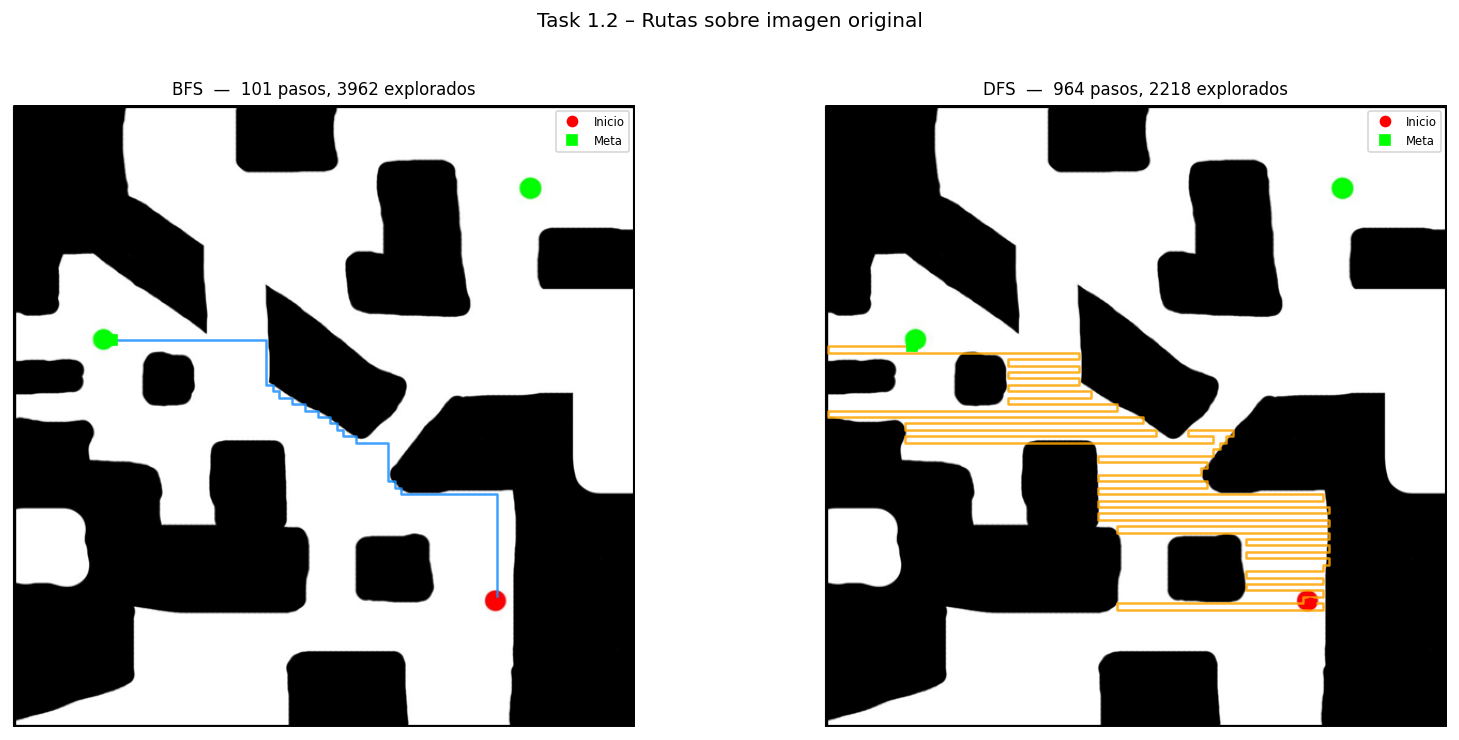

In [56]:
# ── Funciones de visualización ─────────────────────────────────────────────────

def grid_to_pixel(r: int, c: int, tile_size: int) -> Tuple[float, float]:
    """Convierte coordenada de grilla (row, col) al centro del tile en píxeles."""
    px = c * tile_size + tile_size / 2
    py = r * tile_size + tile_size / 2
    return px, py


def draw_path_on_image(
    ax,
    img_array: np.ndarray,
    path: List[State],
    tile_size: int,
    color: str = "blue",
    title: str = "",
) -> None:
    """Dibuja la ruta como una línea sobre la imagen original."""
    ax.imshow(img_array)
    if path:
        xs = [grid_to_pixel(r, c, tile_size)[0] for r, c in path]
        ys = [grid_to_pixel(r, c, tile_size)[1] for r, c in path]
        ax.plot(xs, ys, color=color, linewidth=1.5, alpha=0.85)
        # Marcar inicio y fin
        ax.plot(xs[0], ys[0], "o", color="red", markersize=6, label="Inicio")
        ax.plot(xs[-1], ys[-1], "s", color="lime", markersize=6, label="Meta")
        ax.legend(loc="upper right", fontsize=7)
    ax.set_title(title, fontsize=10)
    ax.axis("off")


# ── Comparación BFS vs DFS ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

draw_path_on_image(
    axes[0], img_array, bfs_result.path, TILE_SIZE,
    color="dodgerblue",
    title=f"BFS  —  {len(bfs_result.path)-1} pasos, {bfs_result.nodes_explored} explorados",
)
draw_path_on_image(
    axes[1], img_array, dfs_result.path, TILE_SIZE,
    color="orange",
    title=f"DFS  —  {len(dfs_result.path)-1} pasos, {dfs_result.nodes_explored} explorados",
)

plt.suptitle("Task 1.2 – Rutas sobre imagen original", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "03_bfs_dfs_original.png"), bbox_inches="tight")
plt.show()

## Task 1.3 – Búsqueda A* (A-star)

Se implementa A* con cola de prioridad (`heapq`). La función de evaluación es:

$$f(n) = g(n) + h(n)$$

donde:
- $g(n)$ = costo acumulado desde el inicio
- $h(n)$ = **distancia Manhattan** al nodo meta más cercano (heurística admisible y consistente)

Inicialmente, el costo de moverse a cualquier celda no-pared es **1**.

In [57]:
# ── Heurística ─────────────────────────────────────────────────────────────────

def manhattan_heuristic(
    state: State, goals: Set[Tuple[int, int]]
) -> float:
    """Distancia Manhattan mínima desde `state` a cualquier meta.

    Es admisible (nunca sobreestima) y consistente para movimiento 4-conexo.
    """
    r, c = state
    return min(abs(r - gr) + abs(c - gc) for gr, gc in goals)


# ── A* Search ─────────────────────────────────────────────────────────────────

def astar(
    problem: SearchProblem,
    heuristic,
) -> SearchResult:
    """Algoritmo A* usando cola de prioridad (min-heap).

    Parameters
    ----------
    problem : SearchProblem
    heuristic : callable(state, goals) -> float

    Returns
    -------
    SearchResult
    """
    start_node = Node(state=problem.initial_state(), path_cost=0.0)
    goals = problem._goals  # acceso directo para la heurística

    # (f(n), counter, node)  —  counter rompe empates determinista
    counter = 0
    open_heap: List[Tuple[float, int, Node]] = []
    h0 = heuristic(start_node.state, goals)
    heapq.heappush(open_heap, (h0, counter, start_node))

    # g-values: mejor costo conocido para llegar a cada estado
    best_g: Dict[State, float] = {start_node.state: 0.0}
    nodes_explored = 0

    while open_heap:
        f_val, _, node = heapq.heappop(open_heap)

        # Si ya procesamos este estado con menor costo, saltar
        if node.path_cost > best_g.get(node.state, float("inf")):
            continue

        nodes_explored += 1

        # Test de meta
        if problem.goal_test(node.state):
            return SearchResult(
                path=node.path(),
                path_cost=node.path_cost,
                nodes_explored=nodes_explored,
                success=True,
            )

        # Expandir
        for action in problem.actions(node.state):
            child_state = problem.result(node.state, action)
            new_g = node.path_cost + problem.step_cost(
                node.state, action, child_state
            )

            # Solo explorar si mejoramos el costo previo
            if new_g < best_g.get(child_state, float("inf")):
                best_g[child_state] = new_g
                h = heuristic(child_state, goals)
                f = new_g + h
                counter += 1
                child_node = Node(
                    state=child_state,
                    parent=node,
                    action=action,
                    path_cost=new_g,
                )
                heapq.heappush(open_heap, (f, counter, child_node))

    return SearchResult(
        path=[], path_cost=float("inf"), nodes_explored=nodes_explored, success=False
    )


# ── Ejecutar A* ──────────────────────────────────────────────────────────────
astar_result = astar(problem, manhattan_heuristic)
print("A*:", astar_result)

A*: SearchResult(✓, pasos=101, costo=101.0, explorados=1283)


### Task 1.3 – Visualización de A* sobre la grilla discreta

Se renderiza la ruta de A* sobre la representación discreta (no la imagen original), según lo pedido en la especificación. Se colorean las celdas por tipo y se superpone la ruta en azul.

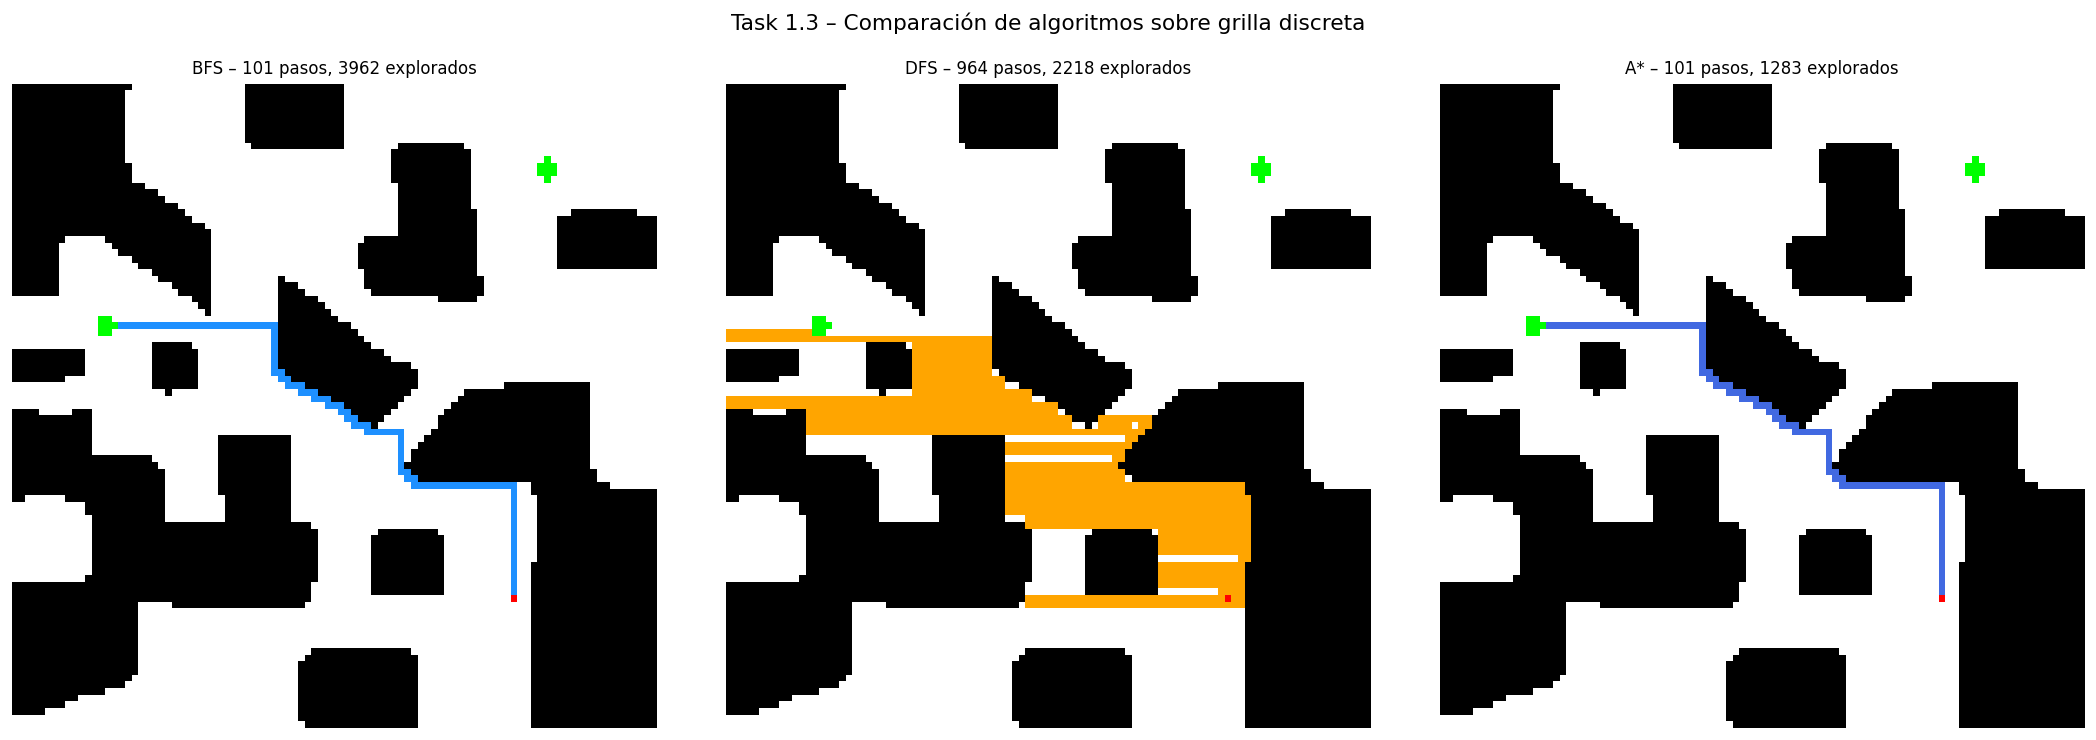

In [58]:
# ── Visualización discreta de A* ──────────────────────────────────────────────

def draw_path_on_grid(
    ax,
    grid: np.ndarray,
    path: List[State],
    title: str = "",
    path_color: List[int] = None,
    explored_color: List[int] = None,
) -> None:
    """Dibuja la ruta sobre la grilla discreta con celdas coloreadas.

    Parameters
    ----------
    ax : matplotlib Axes
    grid : np.ndarray de CellType
    path : lista de (row, col)
    title : título del gráfico
    path_color : color RGB [R, G, B] para la ruta
    explored_color : (no usado aquí, reservado para expansión futura)
    """
    if path_color is None:
        path_color = [65, 105, 225]  # Royal Blue

    rgb = grid_to_rgb(grid).copy()

    # Pintar la ruta
    for r, c in path:
        # No sobrescribir inicio ni meta para mantener claridad visual
        if grid[r, c] not in (CellType.START, CellType.GOAL):
            rgb[r, c] = path_color

    ax.imshow(rgb, interpolation="nearest")
    ax.set_title(title, fontsize=10)
    ax.axis("off")


# ── Comparación final: BFS vs DFS vs A* en grilla discreta ───────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

draw_path_on_grid(
    axes[0], grid, bfs_result.path,
    title=f"BFS – {len(bfs_result.path)-1} pasos, {bfs_result.nodes_explored} explorados",
    path_color=[30, 144, 255],
)

draw_path_on_grid(
    axes[1], grid, dfs_result.path,
    title=f"DFS – {len(dfs_result.path)-1} pasos, {dfs_result.nodes_explored} explorados",
    path_color=[255, 165, 0],
)

draw_path_on_grid(
    axes[2], grid, astar_result.path,
    title=f"A* – {len(astar_result.path)-1} pasos, {astar_result.nodes_explored} explorados",
    path_color=[65, 105, 225],
)

plt.suptitle("Task 1.3 – Comparación de algoritmos sobre grilla discreta", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "04_algorithms_grid.png"), bbox_inches="tight")
plt.show()

### Resumen comparativo

In [59]:
# ── Tabla comparativa ─────────────────────────────────────────────────────────

print(f"{'Algoritmo':<12} {'Pasos':>8} {'Costo':>8} {'Explorados':>12} {'Éxito':>7}")
print("-" * 52)
for name, res in [("BFS", bfs_result), ("DFS", dfs_result), ("A*", astar_result)]:
    steps = len(res.path) - 1 if res.success else "N/A"
    cost = f"{res.path_cost:.1f}" if res.success else "N/A"
    ok = "✓" if res.success else "✗"
    print(f"{name:<12} {str(steps):>8} {cost:>8} {res.nodes_explored:>12} {ok:>7}")

Algoritmo       Pasos    Costo   Explorados   Éxito
----------------------------------------------------
BFS               101    101.0         3962       ✓
DFS               964    964.0         2218       ✓
A*                101    101.0         1283       ✓
